# Productline Predict and Visualize Importance

##### 苏泽 Mamadou Alpha Diallo -> 临沂大学 Linyi University -> Master's Degree -> Information engeneering -> 2nd year.

##### SBA Lab - 2022 November 19, 15:15

In [124]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE


## Data preparation 

In [125]:
# Creating the dataframe from the csv data file.
data0 = pd.read_csv("sales_data_sample.csv",encoding="ISO-8859-1")

In [126]:
display(data0[0:5].T)

,0,1,2,3,4
ORDERNUMBER,10107,10121,10134,10145,10159
QUANTITYORDERED,30,34,41,45,49
PRICEEACH,95.7,81.35,94.74,83.26,100.0
ORDERLINENUMBER,2,5,2,6,14
SALES,2871.0,2765.9,3884.34,3746.7,5205.27
ORDERDATE,2/24/2003 0:00,5/7/2003 0:00,7/1/2003 0:00,8/25/2003 0:00,10/10/2003 0:00
STATUS,Shipped,Shipped,Shipped,Shipped,Shipped
QTR_ID,1,2,3,3,4
MONTH_ID,2,5,7,8,10
YEAR_ID,2003,2003,2003,2003,2003


In [127]:
# 
names0 = data0["PRODUCTLINE"].unique().tolist()

names = sorted(names0)

names

['Classic Cars',
 'Motorcycles',
 'Planes',
 'Ships',
 'Trains',
 'Trucks and Buses',
 'Vintage Cars']

In [128]:
# 
from sklearn.preprocessing import LabelEncoder

In [129]:
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype == 'object':
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df


In [130]:
data1 = labelencoder(data0)

In [131]:
data1

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,112,5,1,2,2003,...,57,5,42,10,0,18,3,76,36,2
1,10121,34,81.35,5,2765.90,185,5,2,5,2003,...,40,5,56,5,27,6,1,28,54,2
2,10134,41,94.74,2,3884.34,204,5,3,7,2003,...,21,5,52,5,41,6,1,17,11,1
3,10145,45,83.26,6,3746.70,226,5,3,8,2003,...,54,5,53,1,49,18,3,75,31,1
4,10159,49,100.00,14,5205.27,23,5,4,10,2003,...,51,5,59,1,63,18,3,8,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,88,5,4,12,2004,...,65,5,34,5,14,14,1,25,13,2
2819,10373,29,100.00,1,3978.51,16,5,1,1,2005,...,87,5,51,5,50,5,1,39,56,1
2820,10386,43,100.00,4,5417.57,119,4,1,3,2005,...,65,5,34,5,14,14,1,25,13,1
2821,10397,34,62.24,1,2116.16,136,5,1,3,2005,...,0,5,68,5,16,6,1,59,5,2


### Target setting

In [132]:
target = ['PRODUCTLINE']
dataY = data1[target]
dataX = data1.drop(target, axis=1)

In [133]:
df_columns = list(dataX.columns)
df_columns

['ORDERNUMBER',
 'QUANTITYORDERED',
 'PRICEEACH',
 'ORDERLINENUMBER',
 'SALES',
 'ORDERDATE',
 'STATUS',
 'QTR_ID',
 'MONTH_ID',
 'YEAR_ID',
 'MSRP',
 'PRODUCTCODE',
 'CUSTOMERNAME',
 'PHONE',
 'ADDRESSLINE1',
 'ADDRESSLINE2',
 'CITY',
 'STATE',
 'POSTALCODE',
 'COUNTRY',
 'TERRITORY',
 'CONTACTLASTNAME',
 'CONTACTFIRSTNAME',
 'DEALSIZE']

In [134]:
m=len(dataX)
print(m)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

trainX=dataX.iloc[M[0:(m//4)*3]]
trainY=dataY.iloc[M[0:(m//4)*3]]
testX=dataX.iloc[M[(m//4)*3:]]
testY=dataY.iloc[M[(m//4)*3:]]

2823


In [135]:
train_df=trainX
test_df=testX

In [140]:
train_df.columns=df_columns
test_df.columns=df_columns 

In [141]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [142]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)
        

In [143]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature
    ]


    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [144]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.23it/s]


createcreate_numeric_feature  0.005[s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 272.25it/s]

createcreate_numeric_feature  0.002[s]


### Model

In [145]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models


In [146]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [147]:
y = trainY
ydf=pd.DataFrame(y)
ydf

,PRODUCTLINE
1029,0
1717,0
368,5
873,0
2807,3
...,...
2588,3
307,0
386,5
2369,6


/var/folders/tw/9gywgrrj5174rvcw7hgjqt5h0000gn/T/ipykernel_80052/2911542305.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.381485
[1000]	valid_0's rmse: 0.360715
[1500]	valid_0's rmse: 0.35807
[2000]	valid_0's rmse: 0.357139
[2500]	valid_0's rmse: 0.356791
[3000]	valid_0's rmse: 0.35652
[3500]	valid_0's rmse: 0.356377
[4000]	valid_0's rmse: 0.356234
Early stopping, best iteration is:
[4119]	valid_0's rmse: 0.356203
fit fold=0  6.853[s]
Fold 0 RMSLE: 0.3562

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.332596
[1000]	valid_0's rmse: 0.309517
[1500]	valid_0's rmse: 0.306948
[2000]	valid_0's rmse: 0.306248
[2500]	valid_0's rmse: 0.30584
[3000]	valid_0's rmse: 0.305659
Early stopping, best iteration is:
[3017]	valid_0's rmse: 0.305647
fit fold=1  9.509[s]
Fold 1 RMSLE: 0.3056

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.422619
[1000]	valid_0's rmse: 0.396188
[1500]	valid_0's rmse: 0.392441
[2000]	valid_0's rmse: 0.391264
[2500]	valid_0's rmse: 0

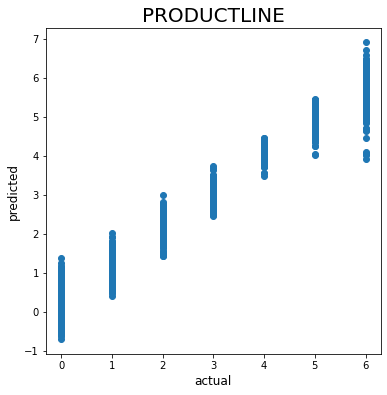

In [148]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(y,oof)

### Visualize importance 

In [149]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

/var/folders/tw/9gywgrrj5174rvcw7hgjqt5h0000gn/T/ipykernel_80052/2911542305.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.381485
[1000]	valid_0's rmse: 0.360715
[1500]	valid_0's rmse: 0.35807
[2000]	valid_0's rmse: 0.357139
[2500]	valid_0's rmse: 0.356791
[3000]	valid_0's rmse: 0.35652
[3500]	valid_0's rmse: 0.356377
[4000]	valid_0's rmse: 0.356234
Early stopping, best iteration is:
[4119]	valid_0's rmse: 0.356203
fit fold=0  4.824[s]
Fold 0 RMSLE: 0.3562

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.332596
[1000]	valid_0's rmse: 0.309517
[1500]	valid_0's rmse: 0.306948
[2000]	valid_0's rmse: 0.306248
[2500]	valid_0's rmse: 0.30584
[3000]	valid_0's rmse: 0.305659
Early stopping, best iteration is:
[3017]	valid_0's rmse: 0.305647
fit fold=1  4.267[s]
Fold 1 RMSLE: 0.3056

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.422619
[1000]	valid_0's rmse: 0.396188
[1500]	valid_0's rmse: 0.392441
[2000]	valid_0's rmse: 0.391264
[2500]	valid_0's rmse: 0

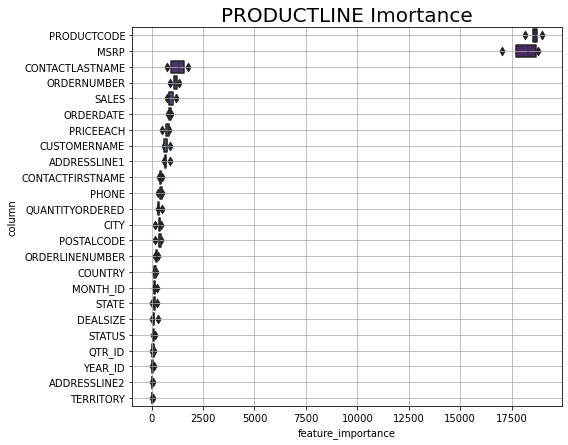

In [150]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [151]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
preds2=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
print(preds2[0:5])

[5.613609784309044, 2.7726401129907363, -0.0959973403535534, 0.14933119826467905, 1.8145697522902502]


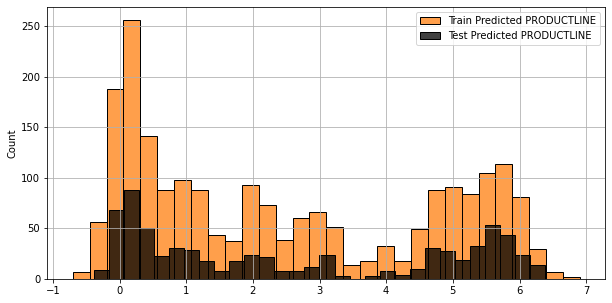

In [152]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

In [157]:
preds2=np.array(preds2)


In [158]:
y_true=testY
y_pred=pd.Series(preds2).apply(lambda x: round(x,0))

In [160]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=names, digits=4))

                  precision    recall  f1-score   support

    Classic Cars     1.0000    0.8730    0.9322       244
     Motorcycles     0.7019    0.9125    0.7935        80
          Planes     0.8933    0.9437    0.9178        71
           Ships     0.9184    0.9783    0.9474        46
          Trains     0.5714    1.0000    0.7273        12
Trucks and Buses     0.5603    0.8904    0.6878        73
    Vintage Cars     1.0000    0.7143    0.8333       182

        accuracy                         0.8545       708
       macro avg     0.8065    0.9017    0.8342       708
    weighted avg     0.8977    0.8545    0.8620       708

